In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import random

from fine_tuning.pretrained_models.bisonai.models import OmniglotModelBisonai

In [2]:
### Parameters

num_classes = 3
learning_rate = 0.001
epochs = 5
checkpoint_path = "fine_tuning/pretrained_models/bisonai/1shot_3way_bisonai_ckpt_o15t/model.ckpt-99999"

def softmax(x):
    e = np.exp(x)
    return (e / np.sum(e, axis=1, keepdims=True))

## Data for fine-tuning & prediction

In [3]:
sess = tf.Session()

omniglot_train = tfds.load(name="omniglot", split=tfds.Split.TRAIN).batch(2000)
omniglot_example = omniglot_train.take(1)
omniglot_example_iter = omniglot_example.make_initializable_iterator()
sess.run(omniglot_example_iter.initializer)

data = omniglot_example_iter.get_next()
image = data['image']
label = data['label']
x, y = sess.run([image,label])

X_train = resize(np.array(x[:num_classes,:,:,:])/255.0, (3, 28, 28, 1))
y_train = np.array(y[:num_classes])

In [4]:
print(X_train.shape)
y_train

(3, 28, 28, 1)


array([ 43, 512, 756])

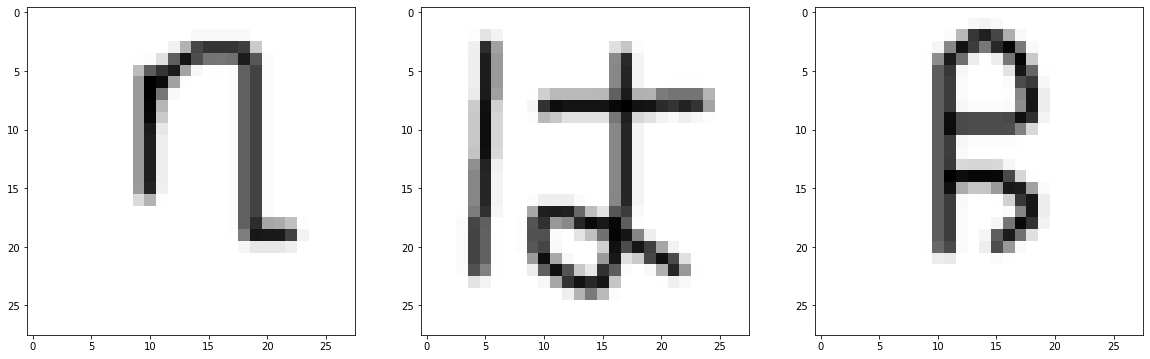

In [5]:
### Showing Images of the 3 classes after reshape 28x28x1

plt.figure(figsize=(20,20))
plt.subplot(131)
imgplot = plt.imshow(X_train[0,:,:,0], cmap="gist_gray")
plt.subplot(132)
imgplot = plt.imshow(X_train[1,:,:,0], cmap="gist_gray")
plt.subplot(133)
imgplot = plt.imshow(X_train[2,:,:,0], cmap="gist_gray")

In [6]:
res = sum([np.where(y == c)[0].tolist() for c in y_train], [])
[res.remove(i) for i in range(num_classes)]

ind = random.choice(res)
X_predict = resize(x[ind,:,:,0]/255.0, (28,28)).reshape((1, 28, 28,1))
y_predict = y[ind]

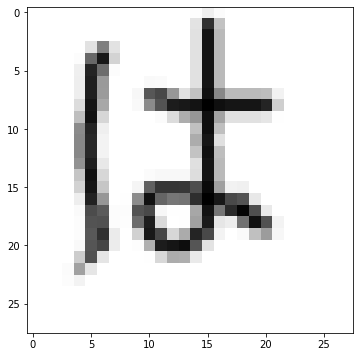

In [7]:
###### Showing the image with class to predict

plt.figure(figsize=(6,6))
imgplot = plt.imshow(X_predict[0,:,:,0], cmap="gist_gray")

## Preparing the model & prediction

In [8]:
model = OmniglotModelBisonai(num_classes=3, **{'learning_rate':learning_rate})
#model = OmniglotModelBisonai(num_classes=3)
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

# for i in tf.all_variables():
#     if "Adam_1" in i.name:
#         sess.run(tf.assign(i,i/(tf.sqrt(i) + 1e-5)))

In [9]:
y_train_label = np.array([0, 1, 2])

adam_var = [i for i in tf.all_variables() if "Adam_1" in i.name]

for e in range(epochs):
#     grad_temp, logits, loss, _ = sess.run([tf.gradients(model.loss, tf.trainable_variables()), model.logits, model.loss, tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)], feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph: y_train_label})
#     #print(grad_temp)
#     print("softmax", softmax(logits))
#     print("loss", loss)
#     for i,j,k in zip(tf.trainable_variables(), grad_temp, adam_var):
#         sess.run(tf.assign(i,i-j*k*learning_rate))
#         #print(sess.run(j*k*learning_rate))

    loss = sess.run(model.loss, feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph: y_train_label})
    print("loss", loss)

    logits = sess.run(model.logits, feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})
    print("test softmax", softmax(logits))
    sess.run(model.minimize_op, feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph:y_train_label})
result, logits = sess.run([model.predictions, model.logits], feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})

print("The predicted class is {} and the real class is {}.".format(y_train[result[0]],y_predict))
print("The probability distribution is {}.".format(softmax(logits)))

loss [1.2374094 1.3336678 0.8046972]
test softmax [[0.335747   0.34607136 0.3181816 ]]
loss [0.04249357 0.00072965 0.02519977]
test softmax [[0.22182344 0.4568719  0.32130465]]
loss [0.03342202 0.00070869 0.02104804]
test softmax [[0.21951723 0.45860305 0.32187977]]
loss [0.0276496  0.00068915 0.01804296]
test softmax [[0.21762924 0.46002695 0.32234374]]
loss [0.02359584 0.00067307 0.01580474]
test softmax [[0.21607248 0.4612106  0.3227169 ]]
The predicted class is 512 and the real class is 512.
The probability distribution is [[0.21476181 0.46220347 0.32303482]].
